In [ ]:
import pandas as pd
df_train = pd.read_csv("/content/drive/MyDrive/signate2/data/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/signate2/data/test.csv")
dataset = {
    "train": df_train,
    "test": df_test
}

In [ ]:
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
# model = SentenceTransformer("all-MiniLM-L6-v2")
model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
dataset = {
    "train": df_train,
    "test": df_test
}

In [ ]:
list(map(len, list(dataset.values())))

[75690, 32439]

# LLM選定
1. paraphrase-MiniLM-L6-v2

*   パラフレーズ判定に強い
2. all-MiniLM-L6-v2

*   テキストの類似度や埋め込みに強い

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import numpy as np
import os

class F01__SentenceTokenize():
  def __init__(self, N=None, is_train=True, pca_n_components=None):
    self.model = SentenceTransformer("all-MiniLM-L6-v2")
    self.data = None
    self.N = N
    self.model_PCA = PCA(n_components=pca_n_components)
    self.is_train = is_train
    self.model_pca_trained = False
    self.data_tokened = None

  def f01__input(self, data):
    if self.N is None:
      self.data = data
    else:
      self.data = data[:self.N]

  # 申し訳程度の前処理
  def f02__preprocess(self):
    # 前処理結果を self.data に反映
    self.data = self.data.apply(lambda x: str(x).replace('"', '')).tolist()

  # トークン化
  def f03__tokenize(self, normalize=True, batch_size=64, show_progress_bar=False):
    self.data_tokened = self.model.encode(
      self.data,
      batch_size=batch_size,
      normalize_embeddings=normalize,
      show_progress_bar=show_progress_bar
    )
    return self.data_tokened

  def f04__PCA(self):
    if self.data_tokened is None:
      raise ValueError("Tokenized embeddings are empty. Run f03__tokenize() first.")

    if self.is_train:
      self.model_pca_trained = True
      return self.model_PCA.fit_transform(self.data_tokened)
    else:
      if not self.model_pca_trained:
        raise RuntimeError("PCA model isn't trained. Fit on train before transforming test to avoid data leakage.")
      return self.model_PCA.transform(self.data_tokened)


dataset_tokenized = {}
dataset_tokenized_pca = {}

instance = F01__SentenceTokenize()

# train
key = "train"
instance.is_train = True
instance.f01__input(dataset[key]["desc"])
instance.f02__preprocess()
dataset_tokenized[key] = instance.f03__tokenize()
dataset_tokenized_pca[key] = instance.f04__PCA()

# test
key = "test"
instance.is_train = False
instance.f01__input(dataset[key]["desc"])
instance.f02__preprocess()
dataset_tokenized[key] = instance.f03__tokenize()
dataset_tokenized_pca[key] = instance.f04__PCA()

# データの保存
save_dir = "/content/drive/MyDrive/signate2/data"
os.makedirs(save_dir, exist_ok=True)

for key, data in dataset_tokenized.items():
  np.save(f"{save_dir}/{key}_raw_0819_2", data)

for key, data in dataset_tokenized_pca.items():
  np.save(f"{save_dir}/{key}_pca_0819_2", data)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<BarContainer object of 384 artists>

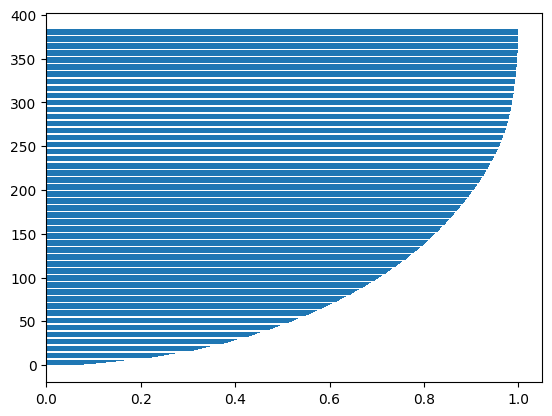

In [ ]:
pca_exp = instance.model_PCA.explained_variance_ratio_.cumsum()

import matplotlib.pyplot as plt
plt.barh(
    y = [i for i in range(len(pca_exp))],
    width = pca_exp
)

In [ ]:
## データのロード
import numpy as np

dataset_tokenized_loaded = {}
for train_test in ["train", "test"]:
  dataset_tokenized_loaded[train_test] = np.load(f"/content/drive/MyDrive/signate2/data/{train_test}.npy")

In [ ]:
dataset_tokenized_loaded["train"].shape

(75690, 384)

In [ ]:
dataset_tokenized_loaded["test"].shape

(32439, 384)

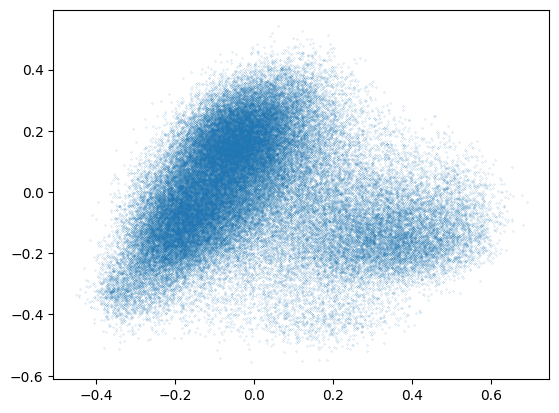

In [ ]:
import matplotlib.pyplot as plt
data = dataset_tokenized_loaded["train"].copy()
plt.scatter(
    data[:, 0], data[:, 1], s=0.01
)

In [ ]:
## どれくらいのクラスタが存在するのか？

↑1000件で16秒くらい
→80000件で1280秒くらい→20分ちょいくらい？